(FL-Numerik)=
# Flüssigwassertransport - Numerische Anwendung
In diesem Kapitel sollen die dem Flüssigwassertransport zu Grunde liegenden Differentialgleichungen in einem einfachen numerischen Modell angewendet werden. Die verwendeten Gleichungen stützen sich auf die Ausführungen in {ref}`FL_Theorie` und {cite}`kalagasidisEvaluationInterfaceMoisture2004`.

Die zur numerischen Lösung der beschreibenden Differentialgleichung verwendeten Bibliotheken und Funktionen können hier eingeblendet werden.

In [1]:
# Matrixoperationen:
import numpy as np
# Numerisches Integrationsverfahren zur Lösung eines Anfangswertproblemes:
from scipy.integrate import solve_ivp
# Darstellung der Ergebnisse:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

## Anwendungsfall
Es soll die Veränderung des Wassergehaltes über die Dauer eines fiktiven eindimesionalen Aufsaugversuches in einem Probekörper nachgerechnet werden. Dieses Modell kann auch verwendet werden um den [Aufsaugversuch der Laborübung](LU_FL) vereinfacht nachzubilden. Eine schematische Darstellung des Probekörpers ist in {numref}`FL_sample` gegeben.

```{figure} img/FL_Numerik/FL_sample_scheme.png
---
height: 250px
name: FL_sample
---
Darstellung des Probekörpers des fiktiven Aufsaugveruches mit den beschreibenden Parametern.
```

## Physikalisches Modell
Die Veränderung des Wassergehaltes nach der Zeit bei Berücksichtigung von Wasserdampfdiffusion und Flüssigwasserleitung kann durch Gleichung {eq}`eq_dw_dt` beschrieben werden

$$
  \frac{\partial w}{\partial t} = - \frac{\partial g_{v}}{\partial x} - \frac{\partial g_{l}}{\partial x}.
$$ (eq_dw_dt)

Dabei ist $g_{v}$ die Feuchtestromdichte zu Folge Wasserdampftransport, Gleichung {eq}`eq_g_v`, und $g_{l}$ die Feuchtestromdichte zu Folge Flüssigwassertransport, Gleichung {eq}`eq_g_l`, in kg/s.

$$
 g_{v} = - \delta_{p} \cdot \frac{\partial p}{\partial x}
$$ (eq_g_v)

$$
 g_{l} = - K \cdot \frac{\partial P_{suc}}{\partial x}
$$ (eq_g_l)

In diesem vereinfachten Beispiel wird der Transport zu Folge Dampfdiffusion vernachlässigt, womit sich Gleichung {eq}`eq_dw_dt` zu Gleichung {eq}`eq_dw_dt_simp` vereinfacht.


$$
  \frac{\partial w}{\partial t} = - \frac{\partial g_{l}}{\partial x}
$$ (eq_dw_dt_simp)

In {
}`kalagasidisEvaluationInterfaceMoisture2004` wird der Wassergehalt in Abhängigkeit der Saugspannung definiert lt. Gleichung {eq}`w_Psuc`.

$$
w(P_{suc}) = 300 \cdot (1 + 10^{-6} \cdot P_{suc})^{-1}
$$ (w_Psuc)

Die Flüssigwasserleitung, als Funktion der Saugspannung und eines freien Parameters n {cite}`bednarBeurteilungFeuchteUnd2000`, kann durch GLeichung {eq}`K_w` beschrieben werden.

$$
K_{w}(P_{suc}, n) = - \frac{\partial w(P_{suc})}{\partial P_{suc}} \cdot \frac{n + 1}{2 n} \cdot \left(\frac{A}{300}\right)^{2} \cdot \left(\frac{w(P_{suc}}{300}\right)^{n} \cdot \left( n + 1 - \left(\frac{w(P_{suc}}{300}\right)^{n}\right)
$$ (K_w)

**Nomenklatur:**

| Parameter    |   | Beschreibung                                |
|--------------|---|---------------------------------------------|
| $A$          |   | Wasseraufnahmekoeffizient in $kg/m²h^{0.5}$ |
| $g$          |   | Feuchtestromdichte in $kg/m²s$              |
| $K$          |   | Flüssigwasserleitung in $s$                 |
| $K_{w}$      |   | Totale hydraulische Leitfähigkeit in $s$    |
| $p$          |   | Wasserdampfpartialdruck in $Pa$             |
| $p_{suc}$    |   | Saugspannung in $Pa$                        |
| $t$          |   | Zeit in $s$  oder $h$                       |
| $w$          |   | Wassergehalt in $kg/m³$                     |
| $x$          |   | Raumkoordinate in x-Richtung in $m$         |
| $\delta_{p}$ |   | Wasserdampfdiffusivität in $kg/m³s$         |



In [2]:
def w_calc(P_suc):
    return 300. * (1. + 10 ** (-6) * P_suc) ** (-1)


def K_w_calc(P_suc, n, A):

    K_w = - (-300. * 10 ** (-6)) / (1. + 10 ** (-6) * P_suc) ** 2 * (n + 1.) / (2. * n) * (A / 300.) ** 2 * (
            w_calc(P_suc) / 300.) ** n * (n + 1 - (w_calc(P_suc) / 300.) ** n)

    return K_w


def P_suc_calc(w, free_saturation, pore_size):

    try:
        P_suc = (300. / w - 1.) / (10 ** (-6))
    except:
        P_suc = 10 ** 9
    return P_suc

 > Für Gleichung {eq}`K_w` wurde dw/dP direkt analytisch berechnet und in die Funktion eingesetzt.

## Numerisches Modell
Zur numerischen Lösung von Gleichung {eq}`eq_dw_dt_simp` muss zunächst das Intervall auf dem die Ergebnisse zu ermitteln sind in endlich viele Teilintervalle diskretisiert werden. In unserem Beispiel bedeutet das, dass unser eindimensionaler fiktiver Versuchskörper eine feste Länge erhält und diese anschließend in eine finite Anzahl aufgeteilt wird, um somit an jedem dieser Diskretisierungspunkte ein Ergebnis berechnen zu können, {numref}`FL_sample_disk`.


```{figure} img/FL_Numerik/FL_sample_disk.png
---
height: 250px
name: FL_sample_disk
---
Probekörper mit Diskretisierungspunkten in einem gleichmäßigen Abstand dx. Die außen liegenden Diskretisierungspunkte geben die Randbedingungen vor.
```

Da sich für solche Diskretisierungsgitter die Arbeit mittels Matrizen anbietet, werden wir mit [Numpy Arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html)  arbeiten.

### Eingangsparameter
Eingangsparameter und Anfangswerte für solch eine Simulation könnten folgendermaßen aussehen:

In [3]:
#-------------------#
#     INPUT         #
#-------------------#

# Sample size
length = 0.2  # meters
resolution = 200 + 2
free_saturation = 300.
n = 13
pore_size = 10 ** (-6)
A = 10.0  # kg/m**2h**0.5  Moisture uptake coefficient
initial_saturation = 1 / 100 * free_saturation

#----------------------------------------------------#

# Discretization Scheme
dx = length / (resolution - 2)
x = np.linspace(dx / 2, length - dx / 2, num=resolution - 2)

# Initialiing starting variables
w = np.full((resolution), initial_saturation, dtype=np.float64)
P_suc = np.zeros(resolution)
K_w = np.zeros(resolution)
dwdt = np.zeros(resolution)

> Resolution ist ein 1D-Array mit der Anzahl an Einträgen welche den Diskretisierungspunkten des Probekörpers entspricht plus 2 für die Randbedingungen.

```{admonition} Hinweis
Hier können Sie die Eingabeparameter anpassen um z.B. Ihren Aufsaugversuch aus der {ref}`LU_FL` nachzurechnen
```

### Randbedingungen
Die Randbedingungen werden für das Beispiel mit $w_{left} = 300\ kg/m³$ und $w_{right} = 60\ kg/m³$ vorgegeben. Wir initialisieren die Randbedingungen entsprechend und berechnen auch für die anderen Parameter, welche vom Wassergehalt abhängig sind, die Randbedingungen.

In [4]:
# BC
w_left = 300
w_right = 60
w[0] = w_left
w[-1] = w_right
P_suc_left = P_suc_calc(w_left, free_saturation, pore_size)
P_suc_right = P_suc_calc(w_right, free_saturation, pore_size)
P_suc[0] = P_suc_left
P_suc[-1] = P_suc_right
K_w_left = K_w_calc(P_suc_left, n, A)
K_w_right = 0
K_w[0] = K_w_left
K_w[-1] = K_w_right

### Numerische Lösung der Differentialgleichung
#### Berechnung der Veränderung des Wassergehaltes nach der Zeit - Approximation mittels FDM
Um eine numerische Lösung der partiellen Differentialgleichung {eq}`eq_dw_dt_simp` zu ermöglichen wird zur Approximation der Lösung die Finite-Differenzen-Methode (FDM) angewandt.

Wenn wir Gleichung {eq}`eq_g_l` in Gleichung {eq}`eq_dw_dt_simp` einsetzen erhalten wir Gleichung {eq}`eq_dw_dt_simp_ges`.

$$
 g_{l} = K \cdot \frac{\partial P_{suc}}{\partial x} \\
 \frac{\partial w}{\partial t} = - \frac{\partial g_{l}}{\partial x} \\
 \frac{\partial w}{\partial t} = - \frac{\partial}{\partial x}\left(K \cdot \frac{\partial P_{suc}}{\partial x}\right)
$$ (eq_dw_dt_simp_ges)

Da sowohl $K$ als auch $P_{suc}$ vom Ort abhängig sind führt Anwendung der Produktregel bei Gleichung {eq}`eq_dw_dt_simp_ges` auf Gleichung {eq}`eq_dw_dt_simp_ges_prod`.

$$
\frac{\partial w}{\partial t} = - \frac{\partial K}{\partial x} \cdot \frac{\partial P_{suc}}{\partial x} + K \cdot \frac{\partial^{2} P_{suc}}{\partial x^{2}}
$$ (eq_dw_dt_simp_ges_prod)

Die diskrete Form von Gleichung {eq}`eq_dw_dt_simp_ges_prod` kann nun zum Beispiel mittels FDM aufgestellt werden und ist in Gleichung {eq}`eq_dw_dt_approx` dargestellt.

$$
\frac{\partial w}{\partial t} = - \frac{\partial K}{\partial x} \cdot \frac{\partial P_{suc}}{\partial x} + K \cdot \frac{\partial^{2} P_{suc}}{\partial x^{2}}) \approx - \frac{K_{O} - K_{U}}{2 \cdot dx} \cdot \frac{P_{O} - P_{U}}{2 \cdot dx} + K_{C} \cdot \frac{P_{O} - 2 P_{C} + P_{U}}{dx^{2}}
$$ (eq_dw_dt_approx)

Dabei steht der Index $O$ für das obere bzw. der Index $U$ für das untere angrenzende Element ausgehend vom eben betrachteten Element, Index $C$ (center), dargestellt in {numref}`grid_index`

```{figure} img/FL_Numerik/grid_index.png
---
height: 250px
name: grid_index
---
Darstellung von 3 Elementen aus der Diskretisierung. Das zu berechnende Element ist mit dem Index $C$ versehen, die angrenzenden Elemente mit dem Index $U$ bzw. $O$.
```

Wir stellen Gleichung {eq}`eq_dw_dt_approx` zur weiteren Verwendung als Funktion dar:

In [5]:
def dwdt_calc(t, w):
    P_suc[:] = P_suc_calc(w, free_saturation, pore_size)
    K_w[:] = K_w_calc(P_suc[:], n, A)

    dwdt = np.full((resolution), 0, dtype=np.float64)

    dwdt[1:-1] = -((K_w[2:] - K_w[:-2]) / (2 * dx) * (P_suc[2:] - P_suc[:-2]) / (2 * dx) +
                   K_w[1:-1] * (P_suc[2:] - 2 * P_suc[1:-1] + P_suc[:-2]) / dx ** 2)

    # Für die Zellen der Randbedingung gibt es keine Veränderung des Wassergehalte nach der Zeit
    dwdt[0] = 0
    dwdt[resolution - 1] = 0

    return dwdt

#### Berechnung des Wassergehaltes nach der Zeit - Numerische Integration
Mit Gleichung {eq}`eq_dw_dt_approx` können wir die Veränderung des Wassergehaltes nach der Zeit berechnen. Um den Wassergehalt im Probekörper nach einer bestimmten Zeitdauer zu erhalten müssen wir die Veränderung des Wassergehaltes über die Zeit integrieren, Gleichung {eq}`w_integral`.

$$
w = \int_{}^{} \frac{\partial w}{\partial t} \,dt
$$ (w_integral)

Da die Lösung dieses Integrals nur selten analytisch möglich ist, wird dieses numerisch Integriert. Als Integrationsverfahren wird ein explizites Runge-Kutta Verfahren verwendet (RK45). Die verwendete Funktion `solve_ivp()` zur Lösung des Anfangswertproblemes stammt aus der [SciPy Library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#id2).

Festlegen der zu berechnenden Zeitdauer und des Anfangswertes für den Solver:

In [6]:
#-------------------#
#     INPUT         #
#-------------------#

w0 = w[:]

t0 = 0  # Start time in hours
tf = 1.5  # End time in hours

# Bestimmung des Ausgabeschrittes für den Solver zur Darstellung der Ergebnisse
t_eval = np.linspace(t0, tf, 100)

Lösen der Differentialgleichung und Berechnung des Integrals mittels Solver:

In [21]:
# ----------------------
#       Solve
# ---------------------

print('Solving the differential equation...\n(Ignore error messages due to numerics.)')
# sol = solve_ivp(dwdt_calc, (t0, tf), w0, t_eval=t_eval, dense_output=False, method='Radau', atol=1e-7, rtol=1e-5)
sol = solve_ivp(dwdt_calc, (t0, tf), w0, t_eval=t_eval, dense_output=False, atol=1e-7, rtol=1e-5)

# Input the solution as the new moisture saturation
w[:] = sol.y[:, t_eval.size - 1]

print('Done.')


Solving the differential equation...
(Ignore error messages due to numerics.)


<ipython-input-2-0a5671c1930a>:7: RuntimeWarning: divide by zero encountered in true_divide
  K_w = - (-300. * 10 ** (-6)) / (1. + 10 ** (-6) * P_suc) ** 2 * (n + 1.) / (2. * n) * (A / 300.) ** 2 * (
<ipython-input-2-0a5671c1930a>:2: RuntimeWarning: divide by zero encountered in reciprocal
  return 300. * (1. + 10 ** (-6) * P_suc) ** (-1)
<ipython-input-2-0a5671c1930a>:7: RuntimeWarning: overflow encountered in multiply
  K_w = - (-300. * 10 ** (-6)) / (1. + 10 ** (-6) * P_suc) ** 2 * (n + 1.) / (2. * n) * (A / 300.) ** 2 * (
<ipython-input-5-757112eecefc>:7: RuntimeWarning: invalid value encountered in subtract
  dwdt[1:-1] = -((K_w[2:] - K_w[:-2]) / (2 * dx) * (P_suc[2:] - P_suc[:-2]) / (2 * dx) +
<ipython-input-5-757112eecefc>:8: RuntimeWarning: invalid value encountered in multiply
  K_w[1:-1] * (P_suc[2:] - 2 * P_suc[1:-1] + P_suc[:-2]) / dx ** 2)
<ipython-input-5-757112eecefc>:7: RuntimeWarning: invalid value encountered in add
  dwdt[1:-1] = -((K_w[2:] - K_w[:-2]) / (2 * dx) * (

Done.


## Darstellung der Ergebnisse
Die Ergebnisse werden einerseits über die Probekörper-Länge andererseits im gesamten Probekörper gegen die Wurzel der Zeit dargestellt. Es wird dafür Pyplot von der [Matplotlib Library](https://matplotlib.org/stable/tutorials/introductory/pyplot.html) verwendet.

### Verteilung des Wassergehaltes im diskretisierten Probekörper

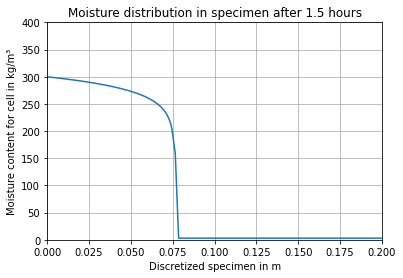

In [17]:
# Moisture content distribution in discretized specimen
w_cell = w[1:-1]
plt.plot(x, w_cell)
plt.grid()
plt.axis([0, 0.2, 0, 400])
plt.xlabel('Discretized specimen in m')
plt.ylabel('Moisture content for cell in kg/m³')
plt.title(f'Moisture distribution in specimen after {tf} hours')
plt.show()

### Wassergehalt im Probekörper gegen $\sqrt{Zeit}$

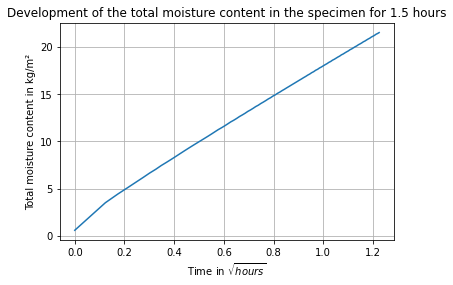

In [9]:
# Moisture content in specimen over square root of time
w_total_dt = np.sum(sol.y[1:-1], axis=0) * dx
t_sqrt_axis = np.sqrt(t_eval)

plt.plot(t_sqrt_axis, w_total_dt)
plt.grid()
plt.xlabel('Time in $\sqrt{hours}$')
plt.ylabel('Total moisture content in kg/m²')
plt.title(f'Development of the total moisture content in the specimen for {tf} hours')
plt.show()

### Relativer Wassergehalt im Probekörper gegen $\sqrt{Zeit}$

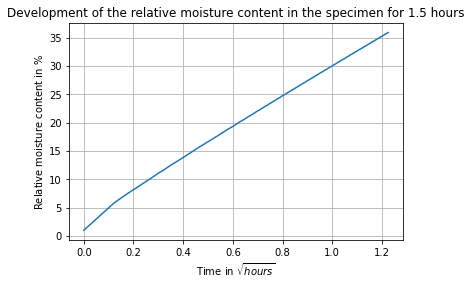

In [10]:
# Relative moisture content in specimen over square root of time
w_rel_dt = w_total_dt / (free_saturation * length) * 100

plt.plot(t_sqrt_axis, w_rel_dt)
plt.grid()
plt.xlabel('Time in $\sqrt{hours}$')
plt.ylabel('Relative moisture content in $\%$')
plt.title(f'Development of the relative moisture content in the specimen for {tf} hours')
plt.show()